This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)

In [2]:
pwd

'/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/202002_first_project'

In [9]:
items = pd.read_csv('/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/data/items.csv')
shops = pd.read_csv('/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/data/shops.csv')
cats = pd.read_csv('/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/data/item_categories.csv')
train = pd.read_csv('/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/data/test.csv').set_index('ID')

In [302]:
items.shape

(22170, 3)

In [303]:
cats.shape

(84, 2)

In [304]:
train.shape

(2935849, 6)

In [305]:
test.shape

(214200, 2)

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

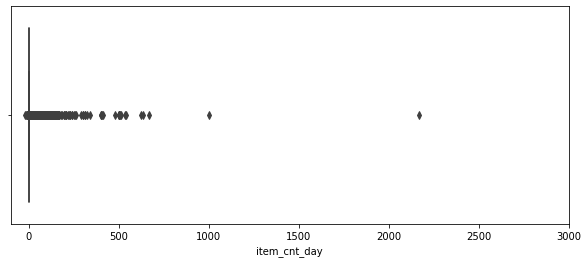

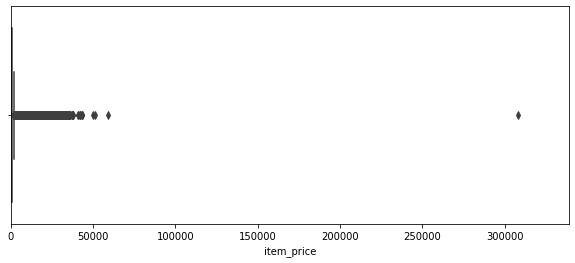

In [306]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [307]:
# 根據圖：去除outlier
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [308]:
train.shape

(2935847, 6)

There is one item with price below zero. Fill it with median.

In [309]:
# 補值：找出相同shop_id與item_id的中位數進行補值
median = train[(train.shop_id == 32) & (train.item_id == 2973) & (
    train.date_block_num == 4) & (train.item_price > 0)].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [310]:
# Якутск Орджоникидзе, 56 其實是同一間店 Якутск Орджоникидзе
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [311]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
# 處理店家名稱：簡化只取前面
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
# 處理城市名稱
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
# 將城市進行編碼：city_code
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [312]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

In [313]:
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

### 網路資源：product

In [163]:
from itertools import product
# It is equivalent to nested for-loops.
# For example, product(A, B) returns the same as ((x,y) for x in A for y in B).
print (list(product([1,2,3],repeat = 2)))

[(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]


In [164]:
# vstack: Stack arrays in sequence vertically (row wise).
a = np.array([1, 2, 3])
b = np.array([2, 3, 4])
np.vstack((a,b))

array([[1, 2, 3],
       [2, 3, 4]])

### Monthly 計算

In [314]:
# Monthly sales: (363, 5100, 214200)
# 1. item_id 只出現在test而沒有出現在train的數量 
# 2. test資料裡面 item_id的數量
# 3. test資料筆數
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [315]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

In [316]:
# 把matrix垂直疊加
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

In [317]:
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

25.858721017837524

In [318]:
matrix.shape

(10913804, 3)

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [319]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [320]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here: 上限到20
                                .astype(np.float16))
time.time() - ts

4.432687759399414

In [321]:
matrix.shape

(10913804, 4)

## Test set
To use time tricks append test pairs to the matrix.

In [322]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [323]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.08849000930786133

In [324]:
matrix.shape

(11128004, 4)

## Shops/Items/Cats features

In [325]:
ts = time.time()
# 串商店、商品作為feature
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

3.3569211959838867

In [326]:
matrix.shape

(11128004, 8)

## Traget lags

In [327]:
# 時間序列變數
# lags: 放入lag的期數
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [328]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

28.467400074005127

In [329]:
matrix.shape

(11128004, 13)

## Mean encoded features

In [330]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
# group: 每一個data_block_num的平均銷售量

In [331]:
# 計算每月平均數量
ts = time.time()
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
# 當天資料test沒有值故drop
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

8.495833158493042

In [332]:
matrix.shape

(11128004, 14)

In [333]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

37.392356872558594

In [334]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

36.66704201698303

In [335]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.86233925819397

In [336]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
# 加入多期lag變數
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

40.657986879348755

In [337]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,12], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

37.30067586898804

In [338]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.877537965774536

In [339]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,12], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

37.607691049575806

In [340]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,12], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

47.86866521835327

In [341]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,12], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

41.46069812774658

In [342]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

20.264424800872803

In [343]:
matrix.shape

(11128004, 48)

## Trend features

Price trend for the last six months.

In [344]:
# 加一個每個商品平均價格欄位
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [345]:
# 新增每一個時間每一個商品的平均價格
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [346]:
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
# 產生 (lag-original)/original的變數: ratio型變數
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In [347]:
# Function to apply to each column or row.
# 滾每一個row，去看是否ratio為0
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]: # 0: False/ 1:True
            return row['delta_price_lag_'+str(i)]
    return 0

In [348]:
# 不懂這串是什麼意思～
# axis = 0: apply function to each column.
# axis = 1: apply function to each row.
# raws: default False --> passes each row or column as a Series to the function.

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

#time.time() - ts

In [65]:
matrix.shape

(11128004, 33)

### 網路資源：first non-null value

In [75]:
from numpy import nan

In [79]:
df = pd.DataFrame([[1, np.nan, 2], [np.nan, 3, np.nan], 
             [np.nan, 4, 5], [np.nan, np.nan, np.nan]], 
             columns=['A', 'B', 'C'])

In [81]:
df

A    B    C
0  1.0  NaN  2.0
1  NaN  3.0  NaN
2  NaN  4.0  5.0
3  NaN  NaN  NaN

In [82]:
df.values[0][0] # 第一個row

1.0

In [88]:
?df.first_valid_index

In [87]:
df.apply(lambda x: x.first_valid_index(), axis=1)

0       A
1       B
2       B
3    None
dtype: object

In [83]:
def func(x):
    if x.values[0] is None: # 滾每一行row，判斷第一個是否為空值
        return None
    else:
        return df.loc[x.name, x.values[0]]
pd.DataFrame(df.apply(lambda x: x.first_valid_index(), axis=1)).apply(func,axis=1)
# pd.first_valid_index(): return index for first non-NA value 

0    1.0
1    3.0
2    4.0
3    NaN
dtype: float64

Last month shop revenue trend

In [66]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

17.8713219165802

## Special features

In [67]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [68]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

### 網路資源：iterrows()

In [97]:
# iterrows returns a Series for each row
df = pd.DataFrame([[1, 1.5],[2,4]], columns=['int', 'float'])
df

int  float
0    1    1.5
1    2    4.0

In [96]:
# next(): Return the next item from the iterator
row = next(df.iterrows())[1]
row

int      1.0
float    1.5
Name: 0, dtype: float64

In [69]:
#ts = time.time()
cache = {}
# 新增欄位item_shop_last_sale = -1 
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
# 迴圈rows
for idx, row in matrix.iterrows():    
    # 商品+商店字串作為key值
    key = str(row.item_id)+' '+str(row.shop_id)
    # print('key', key)
    if key not in cache: 
        if row.item_cnt_month!=0:
            # print('item_cnt_month', row.date_block_num)
            # 創立cache字典：商品+商店:每一天的數量
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
#time.time() - ts

In [70]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

802.3781461715698

In [71]:
matrix.shape

(11128004, 38)

Months since the first sale for each shop/item pair and for item only.

In [72]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.7248828411102295

In [73]:
matrix.shape

(11128004, 40)

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [349]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

1.1880366802215576

Producing lags brings a lot of nulls.

In [350]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.348116159439087

In [351]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_2', 'date_shop_cat_avg_item_cnt_lag_3',
       'date_shop_cat_avg_item_cnt_lag_6', 'date_shop_cat_avg_item_cnt_lag_12',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_3',
       'date_shop_type_avg

In [352]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
4488710              12        2       27             0.0          0   
4488711              12        2       30             0.0          0   
4488712              12        2       31             0.0          0   
4488713              12        2       32             1.0          0   
4488714              12        2       33             1.0          0   

         item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
4488710                19          5            10                   0.0   
4488711                40         11             4                   0.0   
4488712                37         11             1                   0.0   
4488713                40         11             4                   0.0   
4488714                37         11             1                   1.0   

         item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
4488710                   0.0                   0.0                   0.0   
4488711                   0.0                   0.0                   0.0   
4488712                   0.0                   0.0                   0.0   
4488713                   0.0                   0.0                   0.0   
4488714                   2.0                   0.0                   0.0   

         item_cnt_month_lag_12  date_avg_item_cnt_lag_1  \
4488710                    1.0                 0.411377   
4488711                    0.0                 0.411377   
4488712                    0.0                 0.411377   
4488713                    0.0                 0.411377   
4488714                    1.0                 0.411377   

         date_item_avg_item_cnt_lag_1  date_item_avg_item_cnt_lag_2  \
4488710                      0.086975                      0.044434   
4488711                      1.021484                      1.022461   
4488712                      0.543457                      0.600098   
4488713                      1.934570                      1.799805   
4488714                      0.913086                      0.333252   

         date_item_avg_item_cnt_lag_3  date_item_avg_item_cnt_lag_6  \
4488710                      0.130493                      0.065247   
4488711                      0.521973                      0.891113   
4488712                      0.543457                      0.304443   
4488713                      1.260742                      1.891602   
4488714                      0.717285                      1.000000   

         date_item_avg_item_cnt_lag_12  date_shop_avg_item_cnt_lag_1  \
4488710                       0.155518                      0.148071   
4488711                       0.000000                      0.148071   
4488712                       0.000000                      0.148071   
4488713                       5.378906                      0.148071   
4488714                       1.355469                      0.148071   

         date_shop_avg_item_cnt_lag_2  date_shop_avg_item_cnt_lag_3  \
4488710                      0.100647                       0.08905   
4488711                      0.100647                       0.08905   
4488712                      0.100647                       0.08905   
4488713                      0.100647                       0.08905   
4488714                      0.100647                       0.08905   

         date_shop_avg_item_cnt_lag_6  date_shop_avg_item_cnt_lag_12  \
4488710                      0.096008                       0.141235   
4488711                      0.096008                       0.000000   
4488712                      0.096008                       0.000000   
4488713                      0.096008                       0.141235   
4488714                      0.096008                       0.141235   

         date_cat_avg_item_cnt_lag_1  date_shop_cat_avg_item_cnt_lag_1  \
4488710                     1.082031                          0.955566   
448871

In [81]:
matrix.describe()

date_block_num       shop_id       item_id  item_cnt_month  \
count    6.639294e+06  6.639294e+06  6.639294e+06       6639294.0   
mean     2.199694e+01  3.189465e+01  1.126362e+04             NaN   
std      6.461452e+00  1.724158e+01  6.271893e+03             0.0   
min      1.200000e+01  2.000000e+00  0.000000e+00             0.0   
25%      1.600000e+01  1.700000e+01  5.680000e+03             0.0   
50%      2.200000e+01  3.300000e+01  1.137200e+04             0.0   
75%      2.700000e+01  4.700000e+01  1.653600e+04             0.0   
max      3.400000e+01  5.900000e+01  2.216900e+04            20.0   

          city_code  item_category_id     type_code  subtype_code  \
count  6.639294e+06      6.639294e+06  6.639294e+06  6.639294e+06   
mean   1.553656e+01      4.495836e+01  1.099628e+01  1.953048e+01   
std    7.995480e+00      1.573942e+01  2.978096e+00  2.084926e+01   
min    0.000000e+00      0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.100000e+01      3.700000e+01  1.100000e+01  2.000000e+00   
50%    1.400000e+01      4.000000e+01  1.100000e+01  1.000000e+01   
75%    2.200000e+01      5.600000e+01  1.300000e+01  3.500000e+01   
max    3.000000e+01      8.300000e+01  1.900000e+01  6.400000e+01   

       item_cnt_month_lag_1  item_cnt_month_lag_2  item_cnt_month_lag_3  \
count             6639294.0             6639294.0             6639294.0   
mean                    NaN                   NaN                   NaN   
std                     0.0                   0.0                   0.0   
min                     0.0                   0.0                   0.0   
25%                     0.0                   0.0                   0.0   
50%                     0.0                   0.0                   0.0   
75%                     0.0                   0.0                   0.0   
max                    20.0                  20.0                  20.0   

       item_cnt_month_lag_6  item_cnt_month_lag_12  date_avg_item_cnt_lag_1  \
count             6639294.0              6639294.0             6.639294e+06   
mean                    NaN                    NaN                      NaN   
std                     0.0                    0.0             0.000000e+00   
min                     0.0                    0.0             0.000000e+00   
25%                     0.0                    0.0             2.546387e-01   
50%                     0.0                    0.0             2.722168e-01   
75%                     0.0                    0.0             3.000488e-01   
max                    20.0                   20.0             4.440918e-01   

       date_item_avg_item_cnt_lag_1  date_item_avg_item_cnt_lag_2  \
count                  6.639294e+06                  6.639294e+06   
mean                            NaN                           NaN   
std                    0.000000e+00                  0.000000e+00   
min                    0.000000e+00                  0.000000e+00   
25%                    2.040100e-02                  1.960754e-02   
50%                    8.001709e-02                  8.001709e-02   
75%                    2.399902e-01                  2.399902e-01   
max                    1.940625e+01                  1.940625e+01   

       date_item_avg_item_cnt_lag_3  date_item_avg_item_cnt_lag_6  \
count                  6.639294e+06                  6.639294e+06   
mean                            NaN                           NaN   
std                    0.000000e+00                  0.000000e+00   
min                    0.000000e+00                  0.000000e+00   
25%                    0.000000e+00                  0.000000e+00   
50%                    6.976318e-02                  5.999756e-02   
75%                    2.391357e-01                  2.244873e-01   
max                    1.940625e+01                  1.956250e+01   

       date_item_avg_item_cnt_lag_12  date_shop_avg_item_cnt_lag_1  \
count                   6.639294e+06                  6.63929

### WP - Week 3 特徵: 嘗試製作相關性變數

In [138]:
from sklearn.metrics.pairwise import cosine_similarity
list(matrix.date_type_avg_item_cnt_lag_1)[0]

1.0341796875

In [104]:
lag_cnt = [i for i in matrix.columns if 'item_cnt_month_lag' in i ]

In [105]:
lag_cnt

['item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_6',
 'item_cnt_month_lag_12']

In [146]:
cosine_similarity([matrix.item_cnt_month_lag_1],[matrix.item_cnt_month_lag_12])

array([[0.25793656]])

In [86]:
cosine_similarity([[1, 0, -1]], [[-1,-1, 0]])

array([[-0.5]])

In [ ]:
cosine_similarity([[matrix.item_cnt_month_lag_1.iloc[0]]],[[matrix.item_cnt_month_lag_12.iloc[0]]]).reshape(1)

In [212]:
ff(matrix.iloc[0])[0]

0.7640402268106462

In [222]:
def fff(x):    
    return cosine_similarity(
        [[x.date_shop_avg_item_cnt_lag_1,x.date_shop_avg_item_cnt_lag_2]],
        [[x.date_shop_avg_item_cnt_lag_6,x.date_shop_avg_item_cnt_lag_12]]).reshape(1)[0]

In [213]:
def ff(x):    
    return cosine_similarity(
        [[x.date_item_avg_item_cnt_lag_1,x.date_item_avg_item_cnt_lag_2]],
        [[x.date_item_avg_item_cnt_lag_6,x.date_item_avg_item_cnt_lag_12]]).reshape(1)[0]

In [220]:
def f(x):     
    cos = cosine_similarity(
        [[x.item_cnt_month_lag_1,x.item_cnt_month_lag_2]],
        [[x.item_cnt_month_lag_6,x.item_cnt_month_lag_12]]).reshape(1)[0]
    return cos

In [221]:
matrix['cos_lag_1_12'] = matrix.apply(f, axis=1)
matrix['cos_lagavg_1_12'] = matrix.apply(ff, axis=1)
matrix['cos_lagshop_1_12'] = matrix.apply(fff, axis=1)

In [355]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
4488710              12        2       27             0.0          0   
4488711              12        2       30             0.0          0   
4488712              12        2       31             0.0          0   
4488713              12        2       32             1.0          0   
4488714              12        2       33             1.0          0   

         item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
4488710                19          5            10                   0.0   
4488711                40         11             4                   0.0   
4488712                37         11             1                   0.0   
4488713                40         11             4                   0.0   
4488714                37         11             1                   1.0   

         item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
4488710                   0.0                   0.0                   0.0   
4488711                   0.0                   0.0                   0.0   
4488712                   0.0                   0.0                   0.0   
4488713                   0.0                   0.0                   0.0   
4488714                   2.0                   0.0                   0.0   

         item_cnt_month_lag_12  date_avg_item_cnt_lag_1  \
4488710                    1.0                 0.411377   
4488711                    0.0                 0.411377   
4488712                    0.0                 0.411377   
4488713                    0.0                 0.411377   
4488714                    1.0                 0.411377   

         date_item_avg_item_cnt_lag_1  date_item_avg_item_cnt_lag_2  \
4488710                      0.086975                      0.044434   
4488711                      1.021484                      1.022461   
4488712                      0.543457                      0.600098   
4488713                      1.934570                      1.799805   
4488714                      0.913086                      0.333252   

         date_item_avg_item_cnt_lag_3  date_item_avg_item_cnt_lag_6  \
4488710                      0.130493                      0.065247   
4488711                      0.521973                      0.891113   
4488712                      0.543457                      0.304443   
4488713                      1.260742                      1.891602   
4488714                      0.717285                      1.000000   

         date_item_avg_item_cnt_lag_12  date_shop_avg_item_cnt_lag_1  \
4488710                       0.155518                      0.148071   
4488711                       0.000000                      0.148071   
4488712                       0.000000                      0.148071   
4488713                       5.378906                      0.148071   
4488714                       1.355469                      0.148071   

         date_shop_avg_item_cnt_lag_2  date_shop_avg_item_cnt_lag_3  \
4488710                      0.100647                       0.08905   
4488711                      0.100647                       0.08905   
4488712                      0.100647                       0.08905   
4488713                      0.100647                       0.08905   
4488714                      0.100647                       0.08905   

         date_shop_avg_item_cnt_lag_6  date_shop_avg_item_cnt_lag_12  \
4488710                      0.096008                       0.141235   
4488711                      0.096008                       0.000000   
4488712                      0.096008                       0.000000   
4488713                      0.096008                       0.141235   
4488714                      0.096008                       0.141235   

         date_cat_avg_item_cnt_lag_1  date_shop_cat_avg_item_cnt_lag_1  \
4488710                     1.082031                          0.955566   
448871

### WP - Week 4: 嘗試刪減變數

In [1]:
col = ['date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2','date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_12','date_item_avg_item_cnt_lag_6',
       # WP - Try
        'cos_lag_1_12',
        'cos_lagavg_1_12',
        'cos_lagshop_1_12',
        'delta_price_lag' ,
       # Target / Base
       'date_block_num', 'item_cnt_month'
      ]

In [ ]:
data = data[col]

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
# 將1後面加上3,6,9，看XGBoost的分數變高或變低？
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


In [ ]:
data = matrix 

### WP - Week 5 - 觀察feature imp

In [23]:
data.item_cnt_month.value_counts()

0.0     5719954
1.0      603872
2.0      154552
3.0       60334
4.0       30865
5.0       18356
6.0       11694
7.0        7896
20.0       6736
8.0        5872
9.0        4230
10.0       3335
11.0       2414
12.0       2001
13.0       1642
14.0       1335
15.0       1103
16.0        943
17.0        821
18.0        717
19.0        622
Name: item_cnt_month, dtype: int64

In [28]:
# Test Data沒有Y所以全為0
data[data.date_block_num==33].item_cnt_month.value_counts()
#Y:item_cnt_month

0.0     206701
1.0      21351
2.0       5070
3.0       1907
4.0        959
5.0        582
6.0        341
20.0       261
7.0        226
8.0        158
9.0        138
10.0       103
11.0        65
12.0        63
13.0        54
15.0        50
14.0        46
16.0        34
18.0        25
17.0        21
19.0        17
Name: item_cnt_month, dtype: int64

In [20]:
data[data.date_block_num==34].count()

date_block_num                          214200
shop_id                                 214200
item_id                                 214200
item_cnt_month                          214200
city_code                               214200
item_category_id                        214200
type_code                               214200
subtype_code                            214200
item_cnt_month_lag_1                    214200
item_cnt_month_lag_2                    214200
item_cnt_month_lag_3                    214200
item_cnt_month_lag_6                    214200
item_cnt_month_lag_12                   214200
date_avg_item_cnt_lag_1                 214200
date_item_avg_item_cnt_lag_1            214200
date_item_avg_item_cnt_lag_2            214200
date_item_avg_item_cnt_lag_3            214200
date_item_avg_item_cnt_lag_6            214200
date_item_avg_item_cnt_lag_12           214200
date_shop_avg_item_cnt_lag_1            214200
date_shop_avg_item_cnt_lag_2            214200
date_shop_avg

### 儲存pickle檔

In [225]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [3]:
path = '/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/data/'

In [4]:
data = pd.read_pickle(path+'data.pkl')

Select perfect features

In [284]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
    # WP - Try
    'cos_lag_1_12',
    'cos_lagavg_1_12',
    'cos_lagshop_1_12',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

### WP - 重新切分train/val

In [5]:
# 創立字典：對應date_block_num的數量
mapping = {}
for i, idx in enumerate(data.date_block_num.value_counts(sort=True).index):
    print(i)
    mapping[idx] = data.date_block_num.value_counts(sort=True).tolist()[i]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [6]:
# 創立字典：對應date_block_num的數量
for i in data.date_block_num.value_counts(sort=True).index:
    print(i)

12
14
15
18
23
21
13
16
17
19
22
24
20
25
26
27
33
28
30
29
32
31
34


In [8]:
train_id_list = [] 
for i in mapping.keys():
    print(i)
    train_id_list.extend(data[data.date_block_num < 34].loc[data.date_block_num == i].iloc[0:round(mapping[i]*0.8)].index.tolist())

12
14
15
18
23
21
13
16
17
19
22
24
20
25
26
27
33
28
30
29
32
31
34


In [22]:
train_id_list

[4488710,
 4488711,
 4488712,
 4488713,
 4488714,
 4488715,
 4488716,
 4488717,
 4488718,
 4488719,
 4488720,
 4488721,
 4488722,
 4488723,
 4488724,
 4488725,
 4488726,
 4488727,
 4488728,
 4488729,
 4488730,
 4488731,
 4488732,
 4488733,
 4488734,
 4488735,
 4488736,
 4488737,
 4488738,
 4488739,
 4488740,
 4488741,
 4488742,
 4488743,
 4488744,
 4488745,
 4488746,
 4488747,
 4488748,
 4488749,
 4488750,
 4488751,
 4488752,
 4488753,
 4488754,
 4488755,
 4488756,
 4488757,
 4488758,
 4488759,
 4488760,
 4488761,
 4488762,
 4488763,
 4488764,
 4488765,
 4488766,
 4488767,
 4488768,
 4488769,
 4488770,
 4488771,
 4488772,
 4488773,
 4488774,
 4488775,
 4488776,
 4488777,
 4488778,
 4488779,
 4488780,
 4488781,
 4488782,
 4488783,
 4488784,
 4488785,
 4488786,
 4488787,
 4488788,
 4488789,
 4488790,
 4488791,
 4488792,
 4488793,
 4488794,
 4488795,
 4488796,
 4488797,
 4488798,
 4488799,
 4488800,
 4488801,
 4488802,
 4488803,
 4488804,
 4488805,
 4488806,
 4488807,
 4488808,
 4488809,


In [23]:
X_train = data.loc[data.index.isin(train_id_list)].drop(['item_cnt_month'], axis=1)
Y_train = data.loc[data.index.isin(train_id_list)]['item_cnt_month']
X_valid = data[~data.index.isin(train_id_list)].drop(['item_cnt_month'], axis=1)
Y_valid = data[~data.index.isin(train_id_list)]['item_cnt_month']

In [24]:
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [161]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=100, 
    colsample_bytree=0.65, 
    subsample=0.95, 
    eta=0.05,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 30)

time.time() - ts

/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:42:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:41] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12384	validation_1-rmse:1.11309
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:1.082	validation_1-rmse:1.06013
[2]	validation_0-rmse:1.05272	validation_1-rmse:1.02263
[3]	validation_0-rmse:1.01812	validation_1-rmse:0.997898
[4]	validation_0-rmse:0.986934	validation_1-rmse:0.97425
[5]	validation_0-rmse:0.962673	validation_1-rmse:0.953974
[6]	validation_0-rmse:0.942299	validation_1-rmse:0.934997
[7]	validation_0-rmse:0.923242	validation_1-rmse:0.919159
[8]	validation_0-rmse:0.907661	validation_1-rmse:0.907097
[9]	valida

7398.750267744064

In [162]:
# save the model to disk
import pickle 
filename = 'week5_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [25]:
# load model
import pickle 
with open('week5_model.pkl','rb') as f:
    model = pickle.load(f)

[14:22:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Prediction

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_v4.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train_v4.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test_v4.pickle', 'wb'))

In [21]:
Y_pred = pd.DataFrame(Y_pred)
Y_valid = pd.DataFrame(Y_valid)

NameError: name 'Y_pred' is not defined

In [205]:
Y_pred = Y_pred.rename(columns={0: 'pred'})

In [209]:
df = pd.concat([Y_pred, Y_valid.set_index(Y_pred.index)], axis=1)
print (df)

             pred  item_cnt_month
0        0.047701             0.0
1        0.062245             0.0
2        0.741400             0.0
3        0.200506             1.0
4        0.087263             0.0
...           ...             ...
1499213  0.072983             0.0
1499214  0.032605             0.0
1499215  0.066505             0.0
1499216  0.008800             0.0
1499217  0.049127             0.0

[1499218 rows x 2 columns]


In [214]:
df['diff'] = abs(df.pred - df.item_cnt_month)

In [226]:
df = pd.DataFrame(df)

In [234]:
df = pd.concat([df, X_valid[['date_block_num','shop_id','item_id','city_code','item_category_id']].set_index(df.index)], axis=1)

In [240]:
df[(df['diff'] > 0.05) & (df['date_block_num'] != 34)].date_block_num.value_counts()

23    43155
12    41486
14    40833
13    39893
16    39841
19    39253
17    38825
18    38812
15    38808
22    37693
21    37633
24    35608
20    35330
25    32893
26    32046
27    29989
33    26511
28    26446
31    25233
29    25208
30    24904
32    24774
Name: date_block_num, dtype: int64

In [233]:
X_valid[['date_block_num','shop_id','item_id','city_code','item_category_id']]

date_block_num  shop_id  item_id  city_code  item_category_id
4766587               12       50    17783         24                38
4766588               12       50    17784         24                37
4766589               12       50    17785         24                40
4766590               12       50    17787         24                37
4766591               12       50    17788         24                40
...                  ...      ...      ...        ...               ...
11127999              34       45    18454         20                55
11128000              34       45    16188         20                64
11128001              34       45    15757         20                55
11128002              34       45    19648         20                40
11128003              34       45      969         20                37

[1499218 rows x 5 columns]

In [215]:
df.sort_values(by=['diff'], )

pred  item_cnt_month  diff
1038458   0.0             0.0   0.0
262487    0.0             0.0   0.0
262488    0.0             0.0   0.0
569242    0.0             0.0   0.0
654240    0.0             0.0   0.0
...       ...             ...   ...
756940    0.0            20.0  20.0
690651    0.0            20.0  20.0
501864    0.0            20.0  20.0
303951    0.0            20.0  20.0
632477    0.0            20.0  20.0

[1499218 rows x 3 columns]

### Training XGB

In [360]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [266]:
del data
gc.collect();

In [267]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=100, 
    colsample_bytree=0.65, 
    subsample=0.95, 
    eta=0.05,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 30)

time.time() - ts

/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:22:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:22:12] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15421	validation_1-rmse:1.14248
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:1.13141	validation_1-rmse:1.12302
[2]	validation_0-rmse:1.11414	validation_1-rmse:1.10528
[3]	validation_0-rmse:1.09763	validation_1-rmse:1.09515
[4]	validation_0-rmse:1.08463	validation_1-rmse:1.08554
[5]	validation_0-rmse:1.07135	validation_1-rmse:1.075
[6]	validation_0-rmse:1.06061	validation_1-rmse:1.06736
[7]	validation_0-rmse:1.05289	validation_1-rmse:1.06389
[8]	validation_0-rmse:1.04734	validation_1-rmse:1.06094
[9]	validation_0-rms

816.150856256485

In [230]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=50, 
    early_stopping_rounds = 30)

time.time() - ts

/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:20:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:20:20] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.125	validation_1-rmse:1.11671
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:1.08792	validation_1-rmse:1.08255
[2]	validation_0-rmse:1.06094	validation_1-rmse:1.05442
[3]	validation_0-rmse:1.02183	validation_1-rmse:1.03182
[4]	validation_0-rmse:0.992083	validation_1-rmse:1.00976
[5]	validation_0-rmse:0.967444	validation_1-rmse:0.988899
[6]	validation_0-rmse:0.947185	validation_1-rmse:0.97327
[7]	validation_0-rmse:0.926983	validation_1-rmse:0.962021
[8]	validation_0-rmse:0.912437	validation_1-rmse:0.952226
[9]	validati

3215.9927349090576

In [163]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_v4.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train_v4.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test_v4.pickle', 'wb'))

### 讀取預測值table

In [6]:
pwd

'/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/202002_first_project'

In [10]:
v1 = pd.read_csv('/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/output/xgb_submission.csv')
v2 = pd.read_csv('/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/output/xgb_submission_v2.csv')
v3 = pd.read_csv('/Users/weiping/Documents/Python/python_wp/04_Kaggle_Project/output/xgb_submission_v3.csv')

In [361]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=100, 
    colsample_bytree=0.8, 
    subsample=0.95, 
    eta=0.05,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 30)

time.time() - ts

/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:15:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:27] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.1273	validation_1-rmse:1.12376
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:1.08973	validation_1-rmse:1.09105
[2]	validation_0-rmse:1.0589	validation_1-rmse:1.06354
[3]	validation_0-rmse:1.02379	validation_1-rmse:1.04165
[4]	validation_0-rmse:0.996071	validation_1-rmse:1.02357
[5]	validation_0-rmse:0.974199	validation_1-rmse:1.00869
[6]	validation_0-rmse:0.957158	validation_1-rmse:0.995845
[7]	validation_0-rmse:0.941222	validation_1-rmse:0.985539
[8]	validation_0-rmse:0.928205	validation_1-rmse:0.977455
[9]	validati

3274.5590450763702

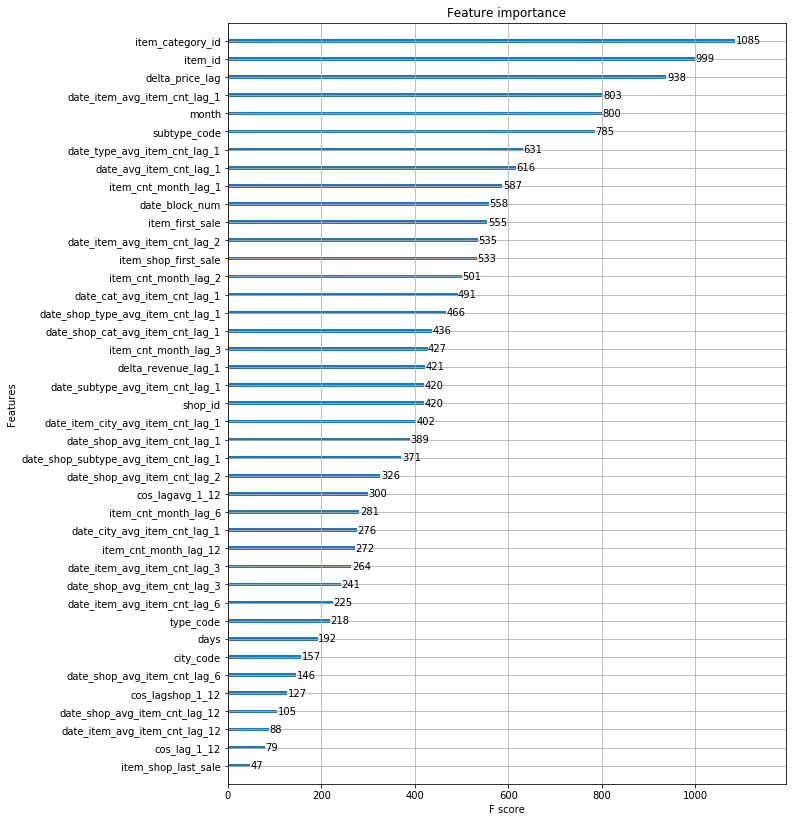

In [171]:
plot_features(model, (10,14))

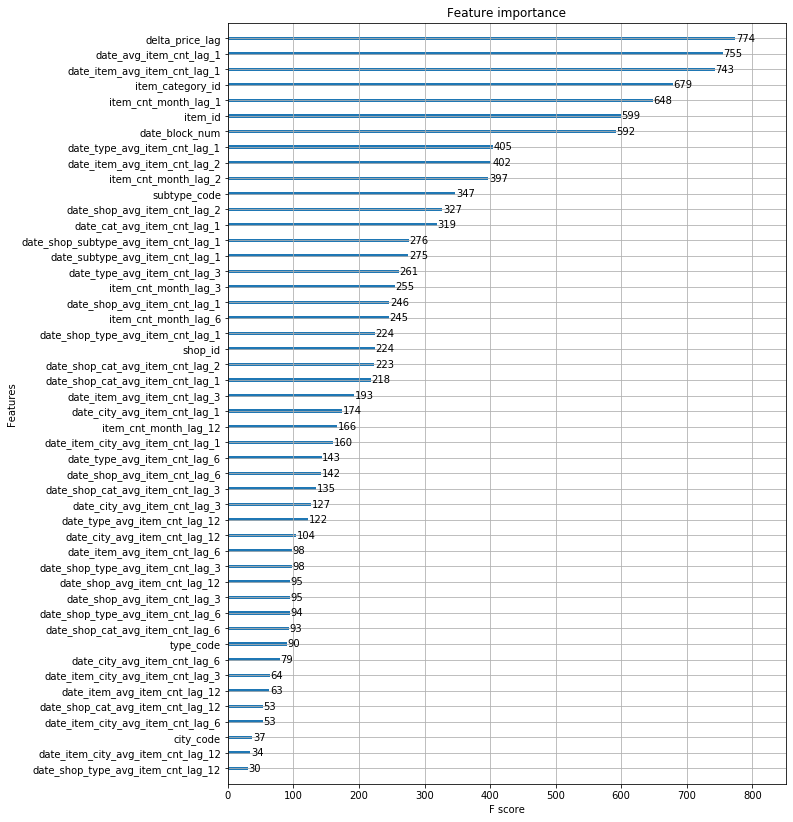

In [362]:
plot_features(model, (10,14))

In [133]:
!ipython nbconvert --to python *.ipynb

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] Converting notebook 00 - ref - time-series.ipynb to python
[NbConvertApp] Writing 25639 bytes to 00 - ref - time-series.py
[NbConvertApp] Converting notebook Kaggle - week2 - feature-engineering-xgboost.ipynb to python
[NbConvertApp] Writing 24393 bytes to Kaggle - week2 - feature-engineering-xgboost.py
[NbConvertApp] Converting notebook Kaggle - Ｗeek1.ipynb to python
[NbConvertApp] Writing 5427 bytes to Kaggle - Ｗeek1.py


### Week 6: 觀察模型結果

In [12]:
# load model
import pickle
with open('week5_model.pkl', 'rb') as f:
    model = pickle.load(f)

[13:59:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [13]:
# print model score
model.base_score

0.5

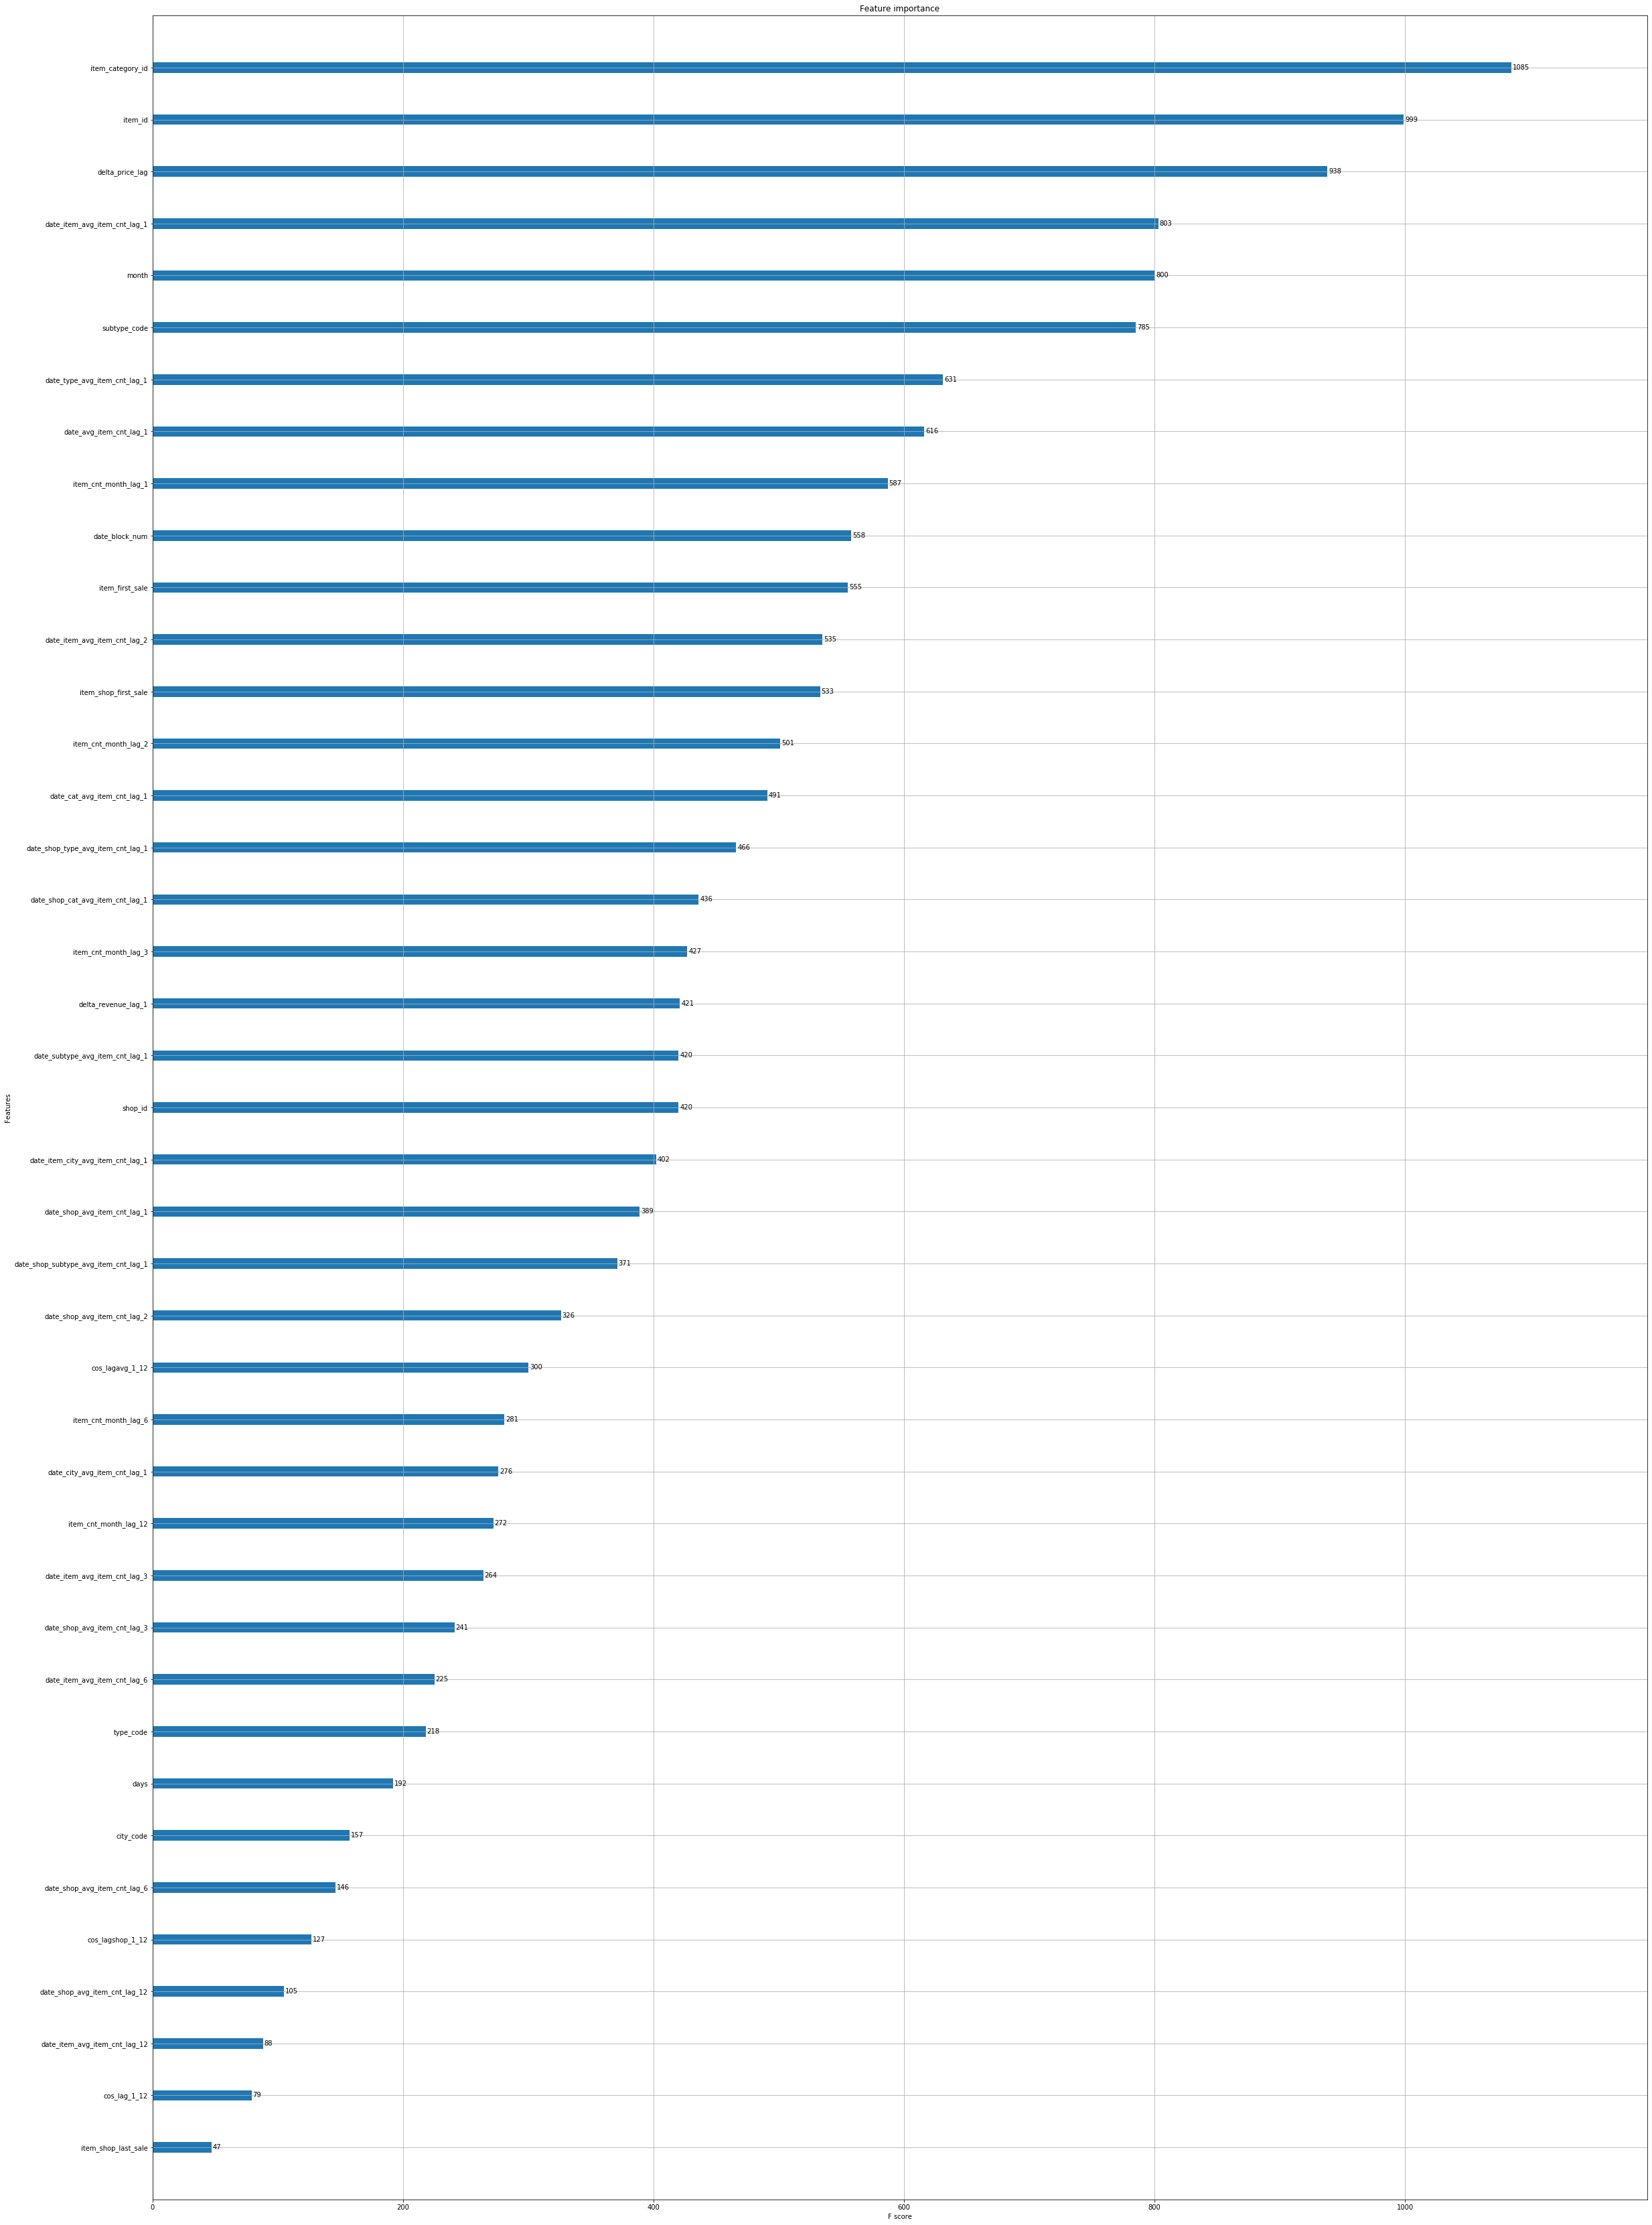

In [17]:
plot_features(model, (40,60))

In [26]:
Y_valid_pred = model.predict(X_valid).clip(0, 20)

In [27]:
# check number
print(X_valid.shape)
print(len(Y_valid_pred))
print(len(Y_valid))

(1499218, 42)
1499218
1499218


In [28]:
# model.evals_result()['validation_0']['rmse'][-1]
# model.evals_result()['validation_1']['rmse'][-1]
from sklearn import metrics, model_selection

print('R2:',metrics.r2_score(Y_valid, Y_valid_pred))
print('MSE:',metrics.mean_squared_error(Y_valid, Y_valid_pred))

R2: 0.43834463750610075
MSE: 0.7233668


In [29]:
X_valid['item_cnt_month']=Y_valid
X_valid['item_cnt_month_Pred']=Y_valid_pred

In [30]:
# 計算預測&實際差異
X_valid['item_cnt_month_diff']=X_valid['item_cnt_month']-X_valid['item_cnt_month_Pred']
X_valid['item_cnt_month_diff_abs']=abs(X_valid['item_cnt_month']-X_valid['item_cnt_month_Pred'])

In [31]:
pd.set_option('display.max_rows', 1000) # default 60
pd.set_option('display.max_columns', 500) # default 20
pd.set_option('display.max_colwidth', -1) # show all the text strings in the column

In [32]:
pd.set_option('float_format', '{:f}'.format)
X_valid[['item_cnt_month_diff','item_cnt_month_diff_abs']].describe()

item_cnt_month_diff  item_cnt_month_diff_abs
count 1499218.000000       1499218.000000          
mean  -0.034031            0.314956                
std   0.849829             0.790044                
min   -20.000000           0.000000                
25%   -0.169444            0.019277                
50%   -0.044312            0.085076                
75%   -0.003293            0.308734                
max   20.000000            20.000000

In [46]:
# 指定後續想分析的欄位（避免顯示太多無關的變數欄位）
col_check=['date_block_num','shop_id','item_id','city_code','item_category_id','type_code','subtype_code','month','days'
            ,'item_cnt_month','item_cnt_month_Pred','item_cnt_month_diff','item_cnt_month_diff_abs']

In [47]:
X_valid[col_check].head()

date_block_num  shop_id  item_id  city_code  item_category_id  \
4766587  12              50       17783    24         38                 
4766588  12              50       17784    24         37                 
4766589  12              50       17785    24         40                 
4766590  12              50       17787    24         37                 
4766591  12              50       17788    24         40                 

         type_code  subtype_code  month  days  item_cnt_month  \
4766587  11         1             0      31   0.000000          
4766588  11         1             0      31   0.000000          
4766589  11         4             0      31   0.000000          
4766590  11         1             0      31   1.000000          
4766591  11         4             0      31   0.000000          

         item_cnt_month_Pred  item_cnt_month_diff  item_cnt_month_diff_abs  
4766587 0.047701             -0.047701            0.047701                  
4766588 0.062245             -0.062245            0.062245                  
4766589 0.741400             -0.741400            0.741400                  
4766590 0.200506             0.799494             0.799494                  
4766591 0.087263             -0.087263            0.087263

In [35]:
# 挑出模型預測很不好的案例（差異超過75%分位）
col_name='item_cnt_month_diff_abs'
diff_75=X_valid[col_name].describe()['75%']
print(diff_75)
X_valid[col_name+'_over75']=np.where(X_valid[col_name]>diff_75,'75up','normal')

0.30873382091522217


In [36]:
# 確認佔總數之比重
X_valid.groupby([col_name+'_over75'])['date_block_num'].count()/X_valid.shape[0]

item_cnt_month_diff_abs_over75
75up     0.250000
normal   0.750000
Name: date_block_num, dtype: float64

In [37]:
X_valid.groupby(['item_category_id',col_name+'_over75']).date_block_num.count()/X_valid.item_category_id.count()

item_category_id  item_cnt_month_diff_abs_over75
0                 75up                             0.000025
                  normal                           0.000003
2                 75up                             0.001072
                  normal                           0.002375
3                 75up                             0.001962
                  normal                           0.001506
4                 75up                             0.000081
                  normal                           0.000283
5                 75up                             0.000511
                  normal                           0.001241
6                 75up                             0.001186
                  normal                           0.001620
7                 75up                             0.000876
                  normal                           0.001312
8                 75up                             0.000079
                  normal                           

In [38]:
## 檢查猜測不好的樣本落在哪些地方
# print all the columns
', '.join(X_valid.columns)

'date_block_num, shop_id, item_id, city_code, item_category_id, type_code, subtype_code, item_cnt_month_lag_1, item_cnt_month_lag_2, item_cnt_month_lag_3, item_cnt_month_lag_6, item_cnt_month_lag_12, date_avg_item_cnt_lag_1, date_item_avg_item_cnt_lag_1, date_item_avg_item_cnt_lag_2, date_item_avg_item_cnt_lag_3, date_item_avg_item_cnt_lag_6, date_item_avg_item_cnt_lag_12, date_shop_avg_item_cnt_lag_1, date_shop_avg_item_cnt_lag_2, date_shop_avg_item_cnt_lag_3, date_shop_avg_item_cnt_lag_6, date_shop_avg_item_cnt_lag_12, date_cat_avg_item_cnt_lag_1, date_shop_cat_avg_item_cnt_lag_1, date_shop_type_avg_item_cnt_lag_1, date_shop_subtype_avg_item_cnt_lag_1, date_city_avg_item_cnt_lag_1, date_item_city_avg_item_cnt_lag_1, date_type_avg_item_cnt_lag_1, date_subtype_avg_item_cnt_lag_1, delta_price_lag, delta_revenue_lag_1, month, days, item_shop_last_sale, item_last_sale, item_shop_first_sale, item_first_sale, cos_lag_1_12, cos_lagavg_1_12, cos_lagshop_1_12, item_cnt_month, item_cnt_month_Pr

In [39]:
# 確認模型猜不好的樣本，都散落在哪些 item_category_id
# crosstab(): 先放列再放行
col='item_category_id'
df_tmp=pd.crosstab(X_valid[col],X_valid['item_cnt_month_diff_abs_over75']
               , normalize=True,margins=True)
df_tmp

item_cnt_month_diff_abs_over75     75up   normal      All
item_category_id                                         
0                              0.000025 0.000003 0.000028
2                              0.001072 0.002375 0.003446
3                              0.001962 0.001506 0.003468
4                              0.000081 0.000283 0.000364
5                              0.000511 0.001241 0.001752
6                              0.001186 0.001620 0.002805
7                              0.000876 0.001312 0.002188
8                              0.000079 0.000219 0.000298
9                              0.000105 0.001031 0.001135
11                             0.000375 0.000920 0.001295
12                             0.000614 0.000241 0.000856
13                             0.000000 0.000032 0.000032
14                             0.000260 0.000715 0.000975
15                             0.000489 0.001019 0.001507
16                             0.000390 0.000559 0.000949
17                             0.000061 0.000409 0.000470
18                             0.000006 0.000012 0.000018
19                             0.011951 0.018008 0.029959
20                             0.006973 0.005354 0.012327
21                             0.001702 0.002634 0.004336
22                             0.002046 0.003772 0.005818
23                             0.011247 0.014049 0.025295
24                             0.003059 0.005023 0.008082
25                             0.002228 0.005976 0.008205
26                             0.000022 0.000166 0.000188
27                             0.000021 0.000057 0.000078
28                             0.005638 0.006742 0.012380
29                             0.000832 0.001249 0.002081
30                             0.015499 0.015089 0.030588
31                             0.003858 0.044793 0.048651
32                             0.000282 0.000140 0.000422
33                             0.000457 0.000646 0.001103
34                             0.000058 0.000592 0.000650
35                             0.000587 0.000069 0.000656
36                             0.000009 0.000099 0.000109
37                             0.019402 0.085870 0.105272
38                             0.004556 0.020773 0.025329
39                             0.000101 0.000434 0.000535
40                             0.055358 0.134133 0.189491
41                             0.003134 0.014390 0.017524
42                             0.000523 0.000044 0.000567
43                             0.002230 0.019994 0.022225
44                             0.000142 0.001205 0.001347
45                             0.000493 0.005584 0.006077
46                             0.000000 0.000047 0.000047
47                             0.001754 0.004889 0.006642
49                             0.001071 0.012705 0.013775
50                             0.000000 0.000012 0.000012
51                             0.000000 0.000007 0.000007
53                             0.000000 0.000007 0.000007
54                             0.000490 0.005233 0.005723
55                             0.037368 0.095601 0.132969
56                             0.000915 0.005792 0.006707
57                             0.005706 0.020628 0.026334
58                             0.001670 0.031819 0.033488
59                             0.000046 0.001492 0.001538
60                             0.000089 0.001597 0.001687
61                             0.001578 0.015855 0.017433
62                             0.001961 0.008456 0.010417
63                             0.006118 0.014369 0.020487
64                             0.004476 0.011750 0.016226
65                             0.005035 0.007131 0.012166
66                             0.000071 0.000769 0.000840
67                             0.003771 0.018338 0.022108
68                             0.000000 0.000006 0.000006
69                             0.002655 0.010876 0.013531
70                             0.003847 0.009410 0.01325

In [40]:
# 去掉不需要用到的列統計值：All
df_tmp.drop('All',inplace=True)

In [41]:
# 計算猜得準相對猜不準的比重(bad-good ratio)
df_tmp['bg_ratio']=df_tmp['75up']/df_tmp['normal']
display(df_tmp.sort_values('75up',ascending=False).head())

item_cnt_month_diff_abs_over75     75up   normal      All  bg_ratio
item_category_id                                                   
40                             0.055358 0.134133 0.189491 0.412710 
55                             0.037368 0.095601 0.132969 0.390875 
37                             0.019402 0.085870 0.105272 0.225947 
30                             0.015499 0.015089 0.030588 1.027231 
19                             0.011951 0.018008 0.029959 0.663642

In [49]:
plt.rcParams['font.family'] = ['Droid Sans Fallback']# 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.rcParams.update({'font.size': 22})

/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29031 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 37559 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21806 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, fla

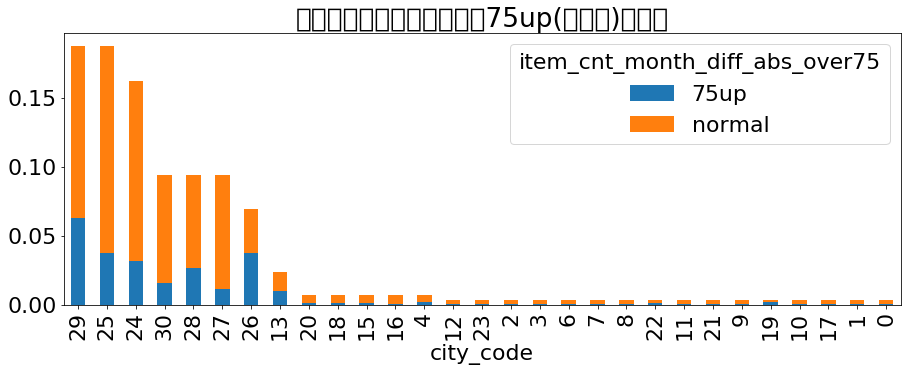

In [50]:
display(df_tmp.sort_values('All',ascending=False)[['75up','normal']].plot.bar(
      stacked=True, figsize=(15,5), title='依照銷售量大到小排列，看75up(猜不准)的分佈'))

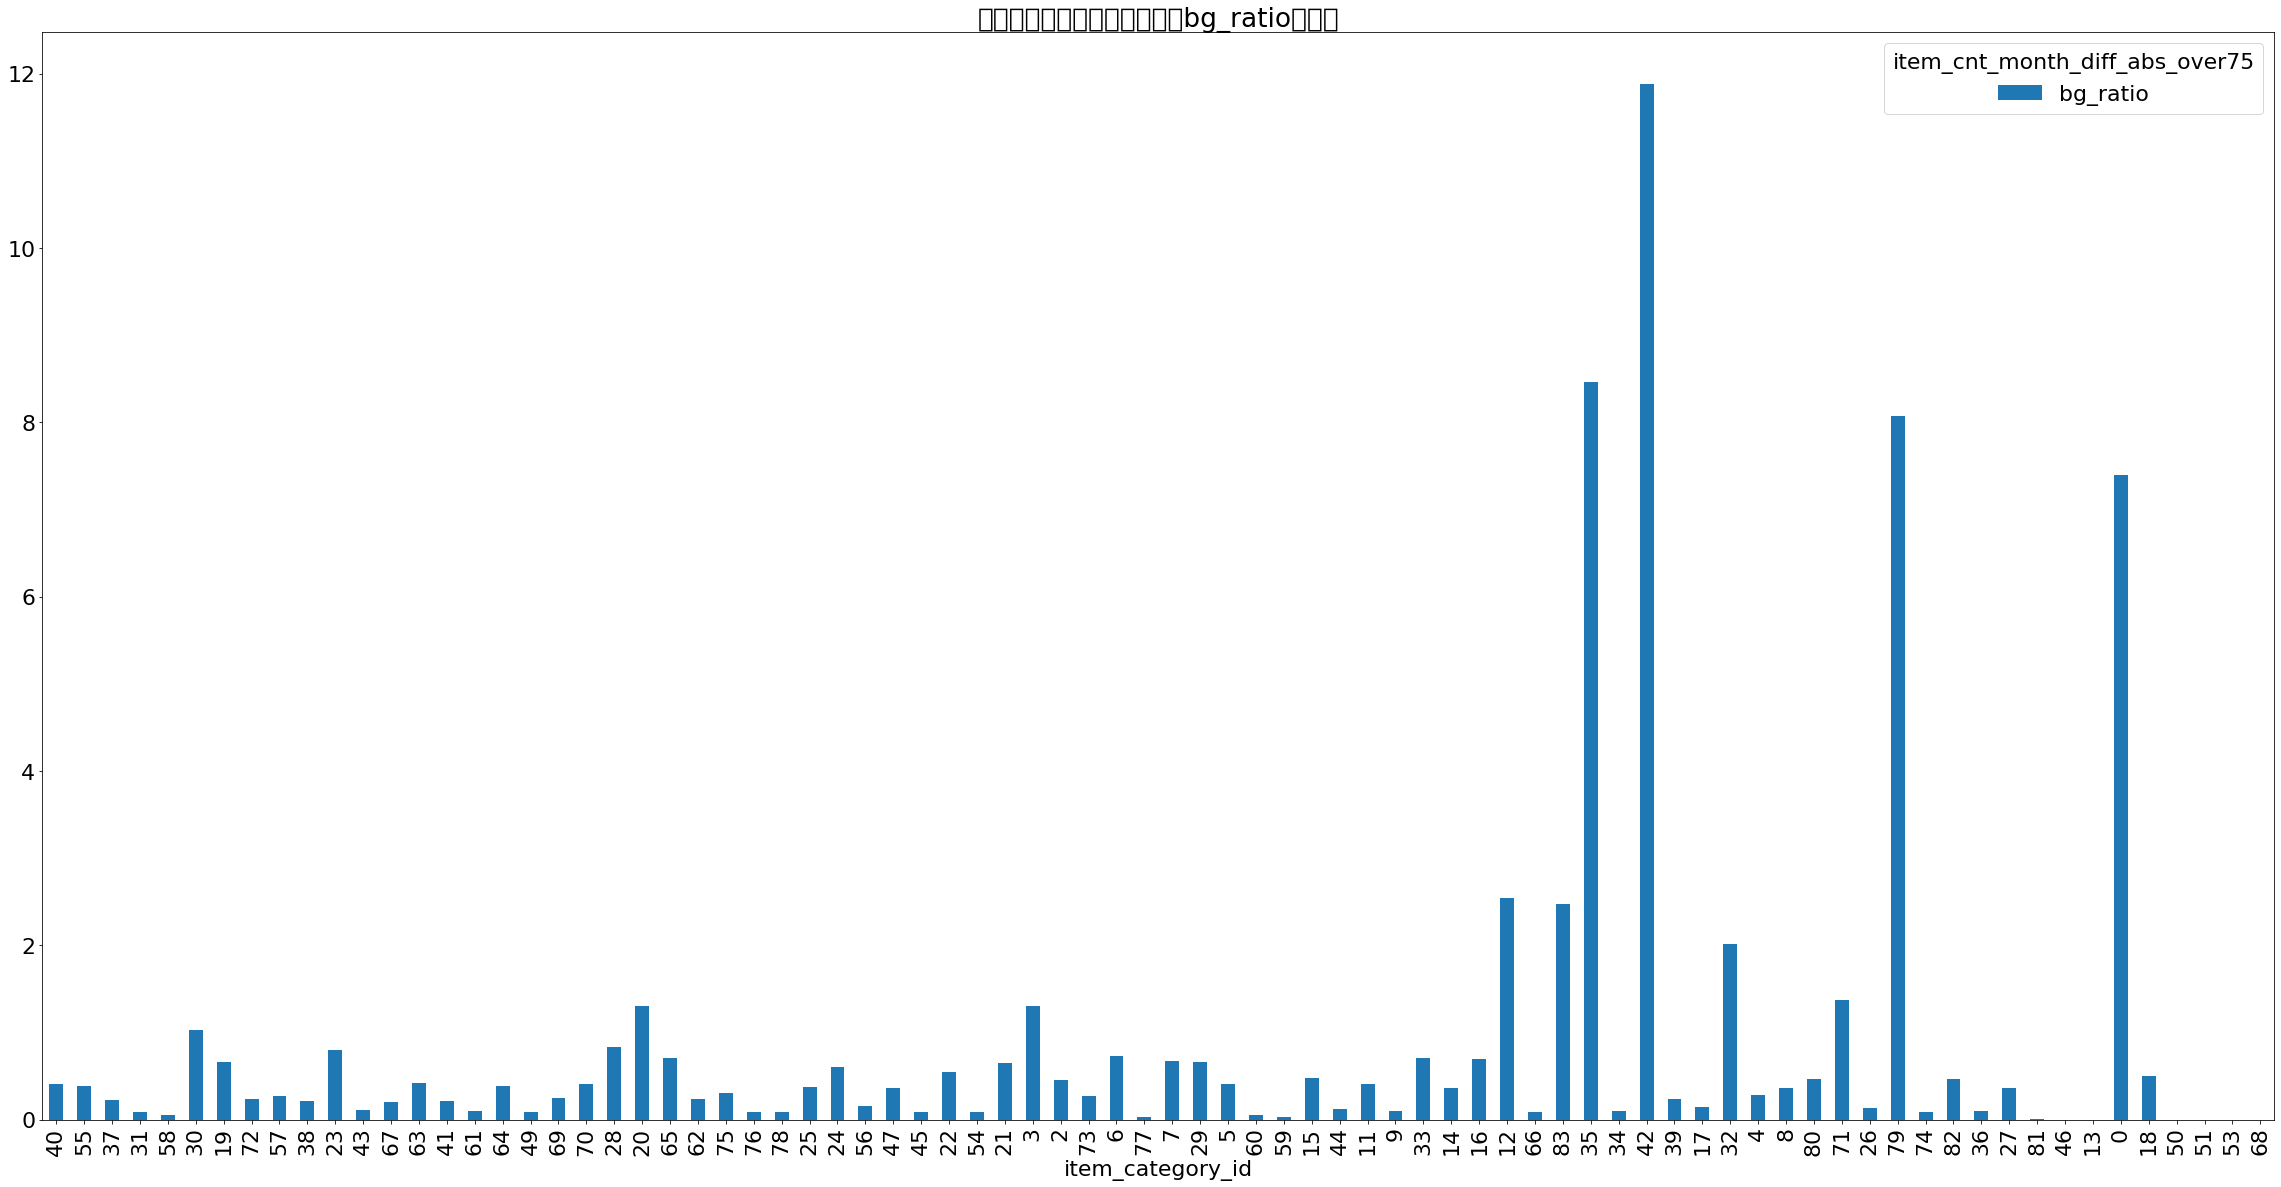

In [44]:
display(df_tmp.sort_values('All',ascending=False)[['bg_ratio']].plot.bar(
stacked=True, figsize=(40,20), title='依照銷售量大到小排列，看看bg_ratio的分佈'))


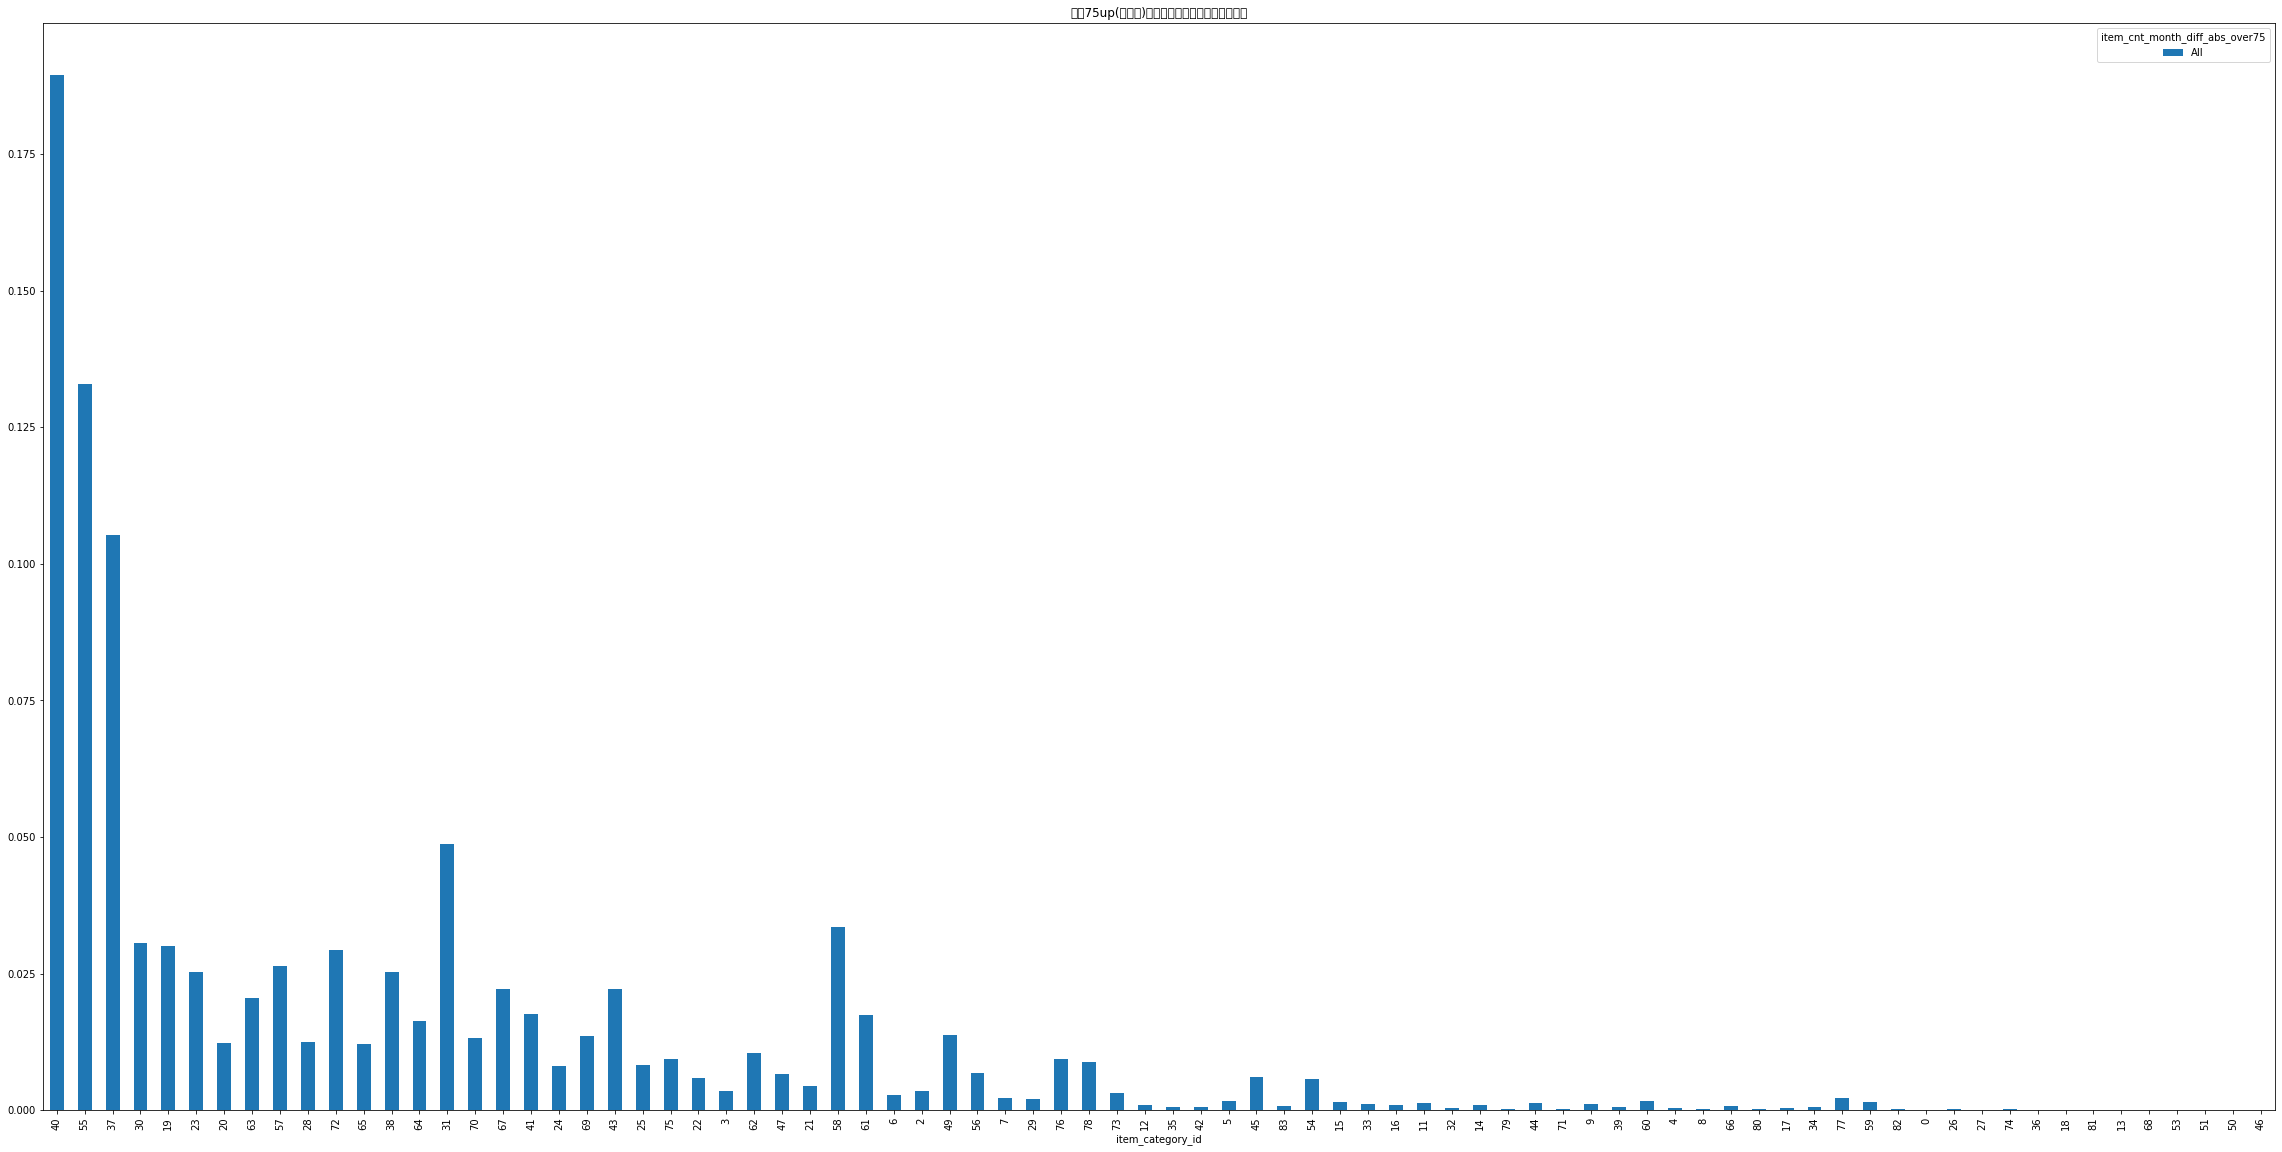

In [79]:
display(df_tmp.sort_values('75up',ascending=False)[['All']].plot.bar(
stacked=True, figsize=(40,20), title='依照75up(猜不準)大到小排列，看看銷售量的分佈'))
# 銷量越大模型越不準

item_cnt_month_diff_abs_over75              75up   normal
item_category_id type_code subtype_code                  
40               11        4            0.055358 0.134133
55               13        2            0.037368 0.095601
37               11        1            0.019402 0.085870
30               8         55           0.015499 0.015089
19               5         10           0.011951 0.018008

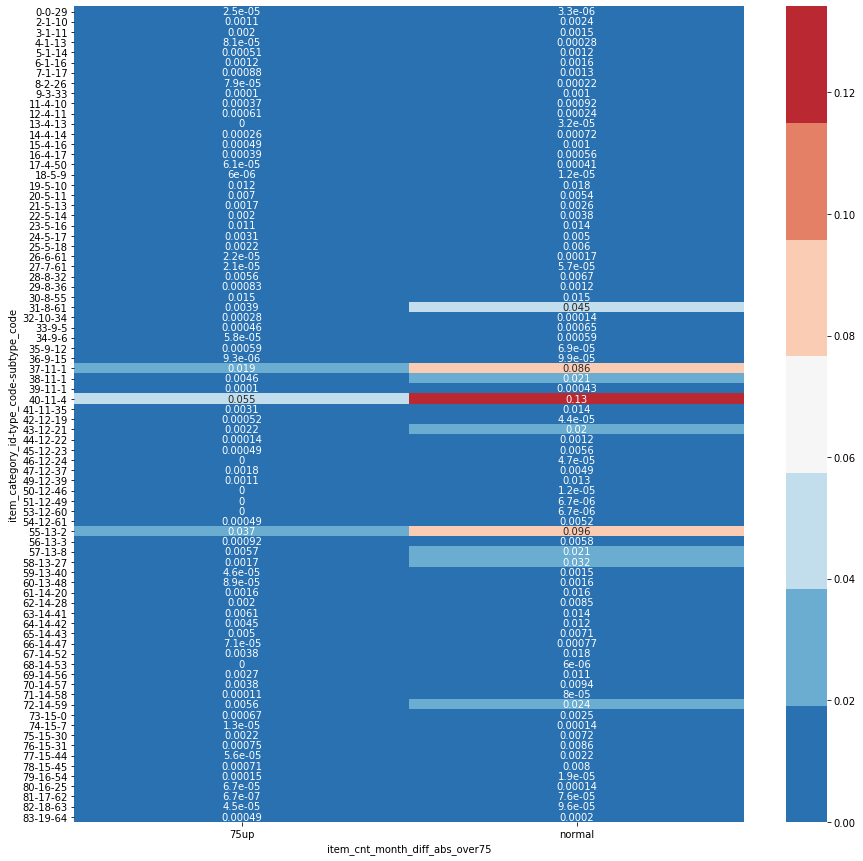

In [81]:
# 確認模型猜不好的樣本，都散落在哪些 item_category_id, type_code, subtype_code
df_tmp=pd.crosstab([X_valid['item_category_id']
                     ,X_valid['type_code'],X_valid['subtype_code']]
                     , [X_valid['item_cnt_month_diff_abs_over75']]
                     , normalize=True)
display(df_tmp.sort_values('75up',ascending=False).head())

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_tmp
   #             , cmap="Blues"
               , cmap=sns.color_palette("RdBu_r", 7)
               , annot=True #, cbar=False
               ,ax=ax
            )


In [85]:
# 確認模型猜不好的樣本，都散落在哪些 city_code
col='city_code'
df_tmp=pd.crosstab(X_valid[col],X_valid['item_cnt_month_diff_abs_over75']
               , normalize=True,margins=True)

In [53]:
# 確認模型猜不好的樣本，都散落在哪些 city_code
col='city_code'
df_tmp=pd.crosstab(X_valid[col],
                   X_valid['item_cnt_month_diff_abs_over75']
                   ,normalize=True,margins=True)
# 去掉不需要用到的列統計值：All
df_tmp.drop('All',inplace=True)
df_tmp

item_cnt_month_diff_abs_over75     75up   normal      All
city_code                                                
0                              0.000502 0.002900 0.003402
1                              0.000409 0.002993 0.003402
2                              0.000452 0.002950 0.003402
3                              0.000628 0.002773 0.003402
4                              0.001687 0.005117 0.006804
6                              0.000350 0.003052 0.003402
7                              0.000797 0.002605 0.003402
8                              0.000620 0.002782 0.003402
9                              0.000666 0.002736 0.003402
10                             0.000590 0.002811 0.003402
11                             0.000683 0.002719 0.003402
12                             0.000825 0.002577 0.003402
13                             0.009797 0.014015 0.023812
15                             0.001251 0.005553 0.006804
16                             0.000844 0.005959 0.006804
17                             0.000644 0.002758 0.003402
18                             0.001029 0.005775 0.006804
19                             0.001782 0.001620 0.003402
20                             0.001033 0.005771 0.006804
21                             0.000714 0.002688 0.003402
22                             0.000978 0.002424 0.003402
23                             0.000641 0.002761 0.003402
24                             0.031338 0.130772 0.162110
25                             0.037125 0.150374 0.187499
26                             0.037788 0.031596 0.069385
27                             0.011381 0.082369 0.093750
28                             0.026518 0.067232 0.093750
29                             0.063053 0.124446 0.187499
30                             0.015878 0.077871 0.093750

In [55]:
# 計算猜得準相對猜不準的比重(bad-good ratio)
df_tmp['bg_ratio']=df_tmp['75up']/df_tmp['normal']
display(df_tmp.sort_values('75up',ascending=False))

item_cnt_month_diff_abs_over75     75up   normal      All  bg_ratio
city_code                                                          
29                             0.063053 0.124446 0.187499 0.506668 
26                             0.037788 0.031596 0.069385 1.195968 
25                             0.037125 0.150374 0.187499 0.246887 
24                             0.031338 0.130772 0.162110 0.239642 
28                             0.026518 0.067232 0.093750 0.394424 
30                             0.015878 0.077871 0.093750 0.203904 
27                             0.011381 0.082369 0.093750 0.138166 
13                             0.009797 0.014015 0.023812 0.699029 
19                             0.001782 0.001620 0.003402 1.099629 
4                              0.001687 0.005117 0.006804 0.329683 
15                             0.001251 0.005553 0.006804 0.225225 
20                             0.001033 0.005771 0.006804 0.178918 
18                             0.001029 0.005775 0.006804 0.178101 
22                             0.000978 0.002424 0.003402 0.403412 
16                             0.000844 0.005959 0.006804 0.141706 
12                             0.000825 0.002577 0.003402 0.320217 
7                              0.000797 0.002605 0.003402 0.306018 
21                             0.000714 0.002688 0.003402 0.265509 
11                             0.000683 0.002719 0.003402 0.251227 
9                              0.000666 0.002736 0.003402 0.243296 
17                             0.000644 0.002758 0.003402 0.233374 
23                             0.000641 0.002761 0.003402 0.232182 
3                              0.000628 0.002773 0.003402 0.226551 
8                              0.000620 0.002782 0.003402 0.222728 
10                             0.000590 0.002811 0.003402 0.209964 
0                              0.000502 0.002900 0.003402 0.172953 
2                              0.000452 0.002950 0.003402 0.153064 
1                              0.000409 0.002993 0.003402 0.136617 
6                              0.000350 0.003052 0.003402 0.114510

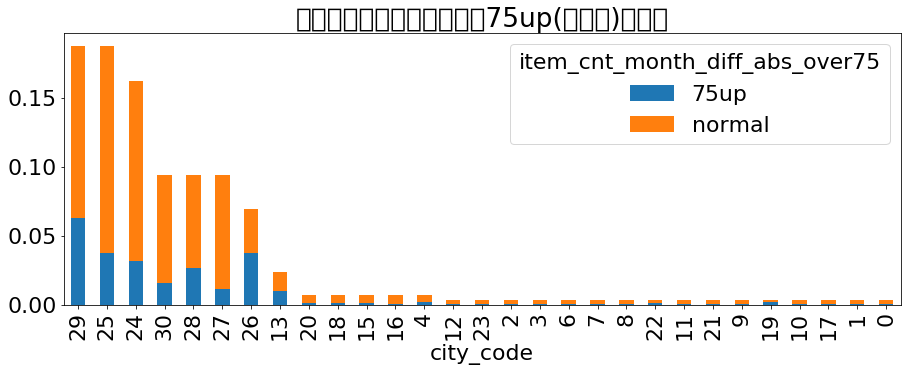

In [56]:
plt.rcParams['font.family'] = ['Droid Sans Fallback']# 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号

display(df_tmp.sort_values('All',ascending=False)[['75up','normal']].plot.bar(
stacked=True, figsize=(15,5), title='依照銷售量大到小排列，看75up(猜不准)的分佈'))

/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 28310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/weiping/Documents/Python/python_wp/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 28310 missing from current font.
  font.set_text(s, 0, flags=flags)


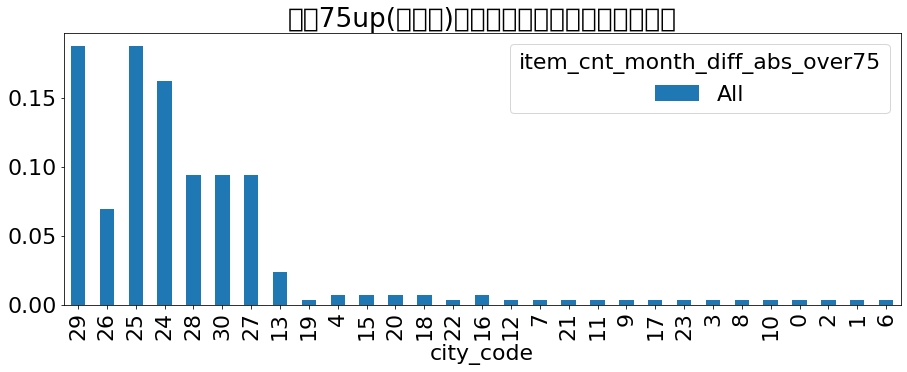

In [58]:
display(df_tmp.sort_values('75up',ascending=False)[['All']].plot.bar(
stacked=True, figsize=(15,5), title='依照75up(猜不準)大到小排列，看看銷售量的分佈'))

In [60]:
# 確認模型猜不好的樣本，都散落在哪些 city_code, item_category_id, type_code, subtype_code
df_tmp=pd.crosstab([X_valid['item_category_id']
                     ,X_valid['type_code'],X_valid['subtype_code'],X_valid['city_code']]
                     , [X_valid['item_cnt_month_diff_abs_over75']]
                     , normalize=True)
df_tmp

item_cnt_month_diff_abs_over75                        75up   normal
item_category_id type_code subtype_code city_code                  
0                0         29           0         0.000001 0.000000
                                        1         0.000000 0.000001
                                        2         0.000000 0.000001
                                        3         0.000001 0.000000
                                        4         0.000001 0.000000
...                                                    ...      ...
83               19        64           26        0.000025 0.000018
                                        27        0.000016 0.000045
                                        28        0.000045 0.000016
                                        29        0.000088 0.000035
                                        30        0.000053 0.000008

[1922 rows x 2 columns]

item_cnt_month_diff_abs_over75                        75up   normal
item_category_id type_code subtype_code city_code                  
40               11        4            29        0.016389 0.019447
55               13        2            29        0.009709 0.015384
40               11        4            24        0.008208 0.024866
                                        26        0.008076 0.005966
                                        28        0.007304 0.010614
                                        25        0.006984 0.028852
55               13        2            26        0.006461 0.002942
                                        25        0.006346 0.018747
37               11        1            29        0.005463 0.014793
55               13        2            24        0.004792 0.016157
                                        28        0.004077 0.008469
37               11        1            26        0.003754 0.004404
40               11        4            30        0.003008 0.014910
37               11        1            24        0.002481 0.016451
                                        25        0.002439 0.017817
55               13        2            30        0.002142 0.010404
37               11        1            28        0.001971 0.008157
40               11        4            13        0.001608 0.001987
55               13        2            13        0.001414 0.001724
37               11        1            30        0.001307 0.008821
40               11        4            27        0.001129 0.016789
37               11        1            13        0.000626 0.000920
55               13        2            27        0.000436 0.012110
37               11        1            27        0.000358 0.009770
40               11        4            19        0.000296 0.000217
55               13        2            19        0.000268 0.000180
40               11        4            4         0.000261 0.000766
55               13        2            4         0.000221 0.000676
40               11        4            15        0.000203 0.000824
                                        20        0.000180 0.000847
55               13        2            15        0.000165 0.000732
40               11        4            18        0.000155 0.000872
                                        22        0.000151 0.000362
                                        12        0.000147 0.000366
55               13        2            20        0.000127 0.000769
37               11        1            19        0.000126 0.000095
55               13        2            22        0.000117 0.000332
40               11        4            21        0.000116 0.000398
                                        9         0.000110 0.000404
37               11        1            4         0.000109 0.000333
40               11        4            3         0.000108 0.000406
                                        16        0.000103 0.000924
55               13        2            11        0.000102 0.000346
                                        16        0.000098 0.000798
                                        18        0.000096 0.000800
40               11        4            11        0.000095 0.000419
                                        23        0.000093 0.000421
55               13        2            12        0.000093 0.000356
37               11        1            15        0.000093 0.000349
55               13        2            23        0.000091 0.000358
40               11        4            8         0.000087 0.000426
                                        2         0.000085 0.000429
                                        10        0.000085 0.000429
                                        1         0.000078 0.000436
                                        17        0.000077 0.000436
37               11        1            7         0.000076 0.000145
40               11        4            0         0.0000

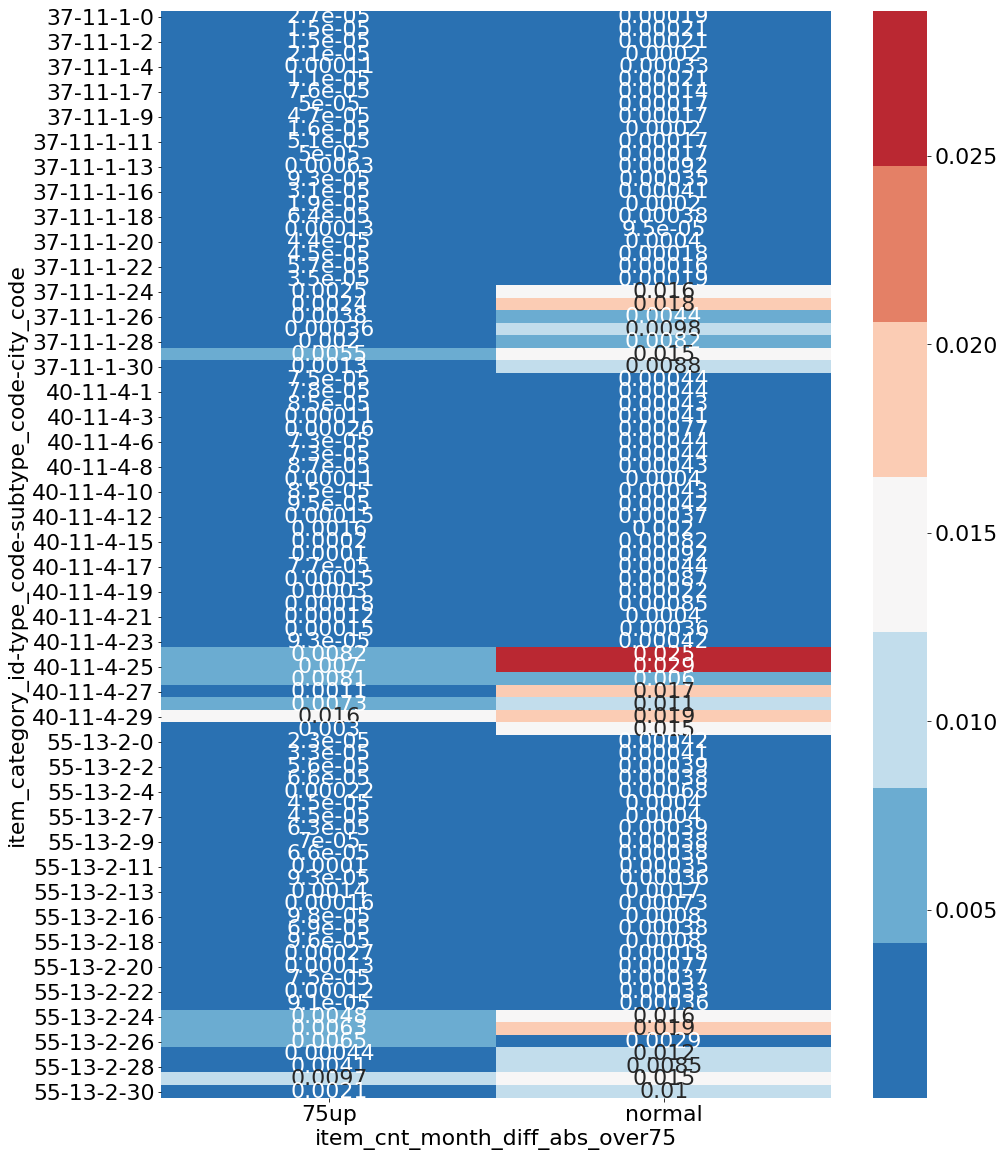

In [62]:
# 只針對75up前三名分析
df_tmp=df_tmp[df_tmp.index.get_level_values('item_category_id').isin(['40','55','37'])]

display(df_tmp.sort_values('75up',ascending=False))

fig, ax = plt.subplots(figsize=(15,20))
sns.heatmap(df_tmp
   #             , cmap="Blues"
               , cmap=sns.color_palette("RdBu_r", 7)
               , annot=True #, cbar=False
               ,ax=ax
            )
